In [1]:
pip install scikit-surprise

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [3]:
from surprise import Dataset, Reader, KNNBasic , KNNWithZScore , KNNWithMeans, SVD
from surprise.model_selection import cross_validate
from collections import defaultdict
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reading a file
retail = pd.read_excel('/Users/suryasaketh/Downloads/OnlineRetail.xlsx')

In [6]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
# Converting invoice date to datetime

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'])

In [7]:
# Items People buy Often

top_items = retail.groupby('Description')['Quantity'].count().sort_values(ascending = False).head(5)

top_items

Description
WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
Name: Quantity, dtype: int64

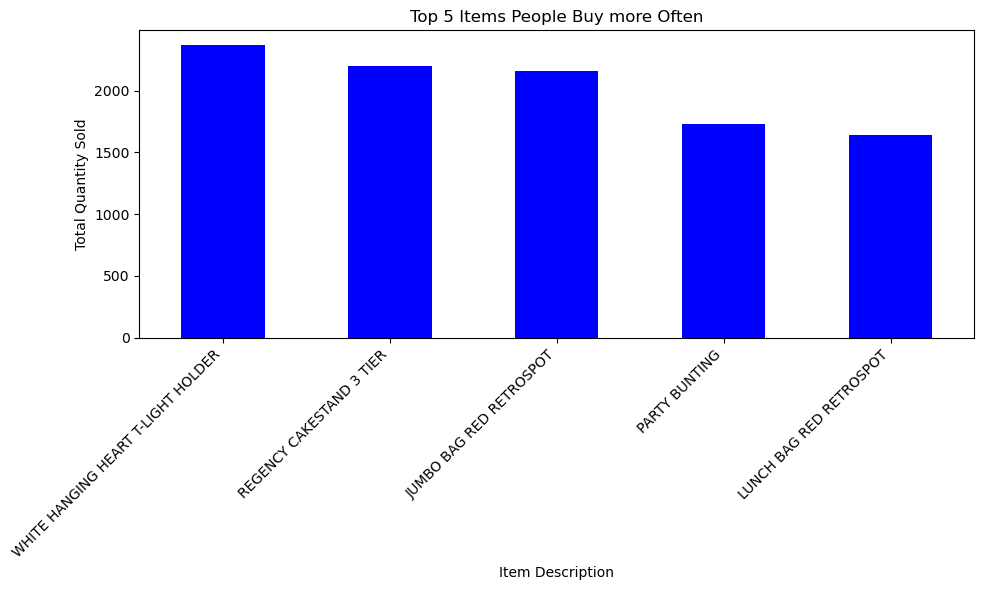

In [8]:

# Plotting 

plt.figure(figsize = (10,6))
top_items.plot(kind = 'bar',color = 'Blue')
plt.title('Top 5 Items People Buy more Often')
plt.xlabel('Item Description')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()

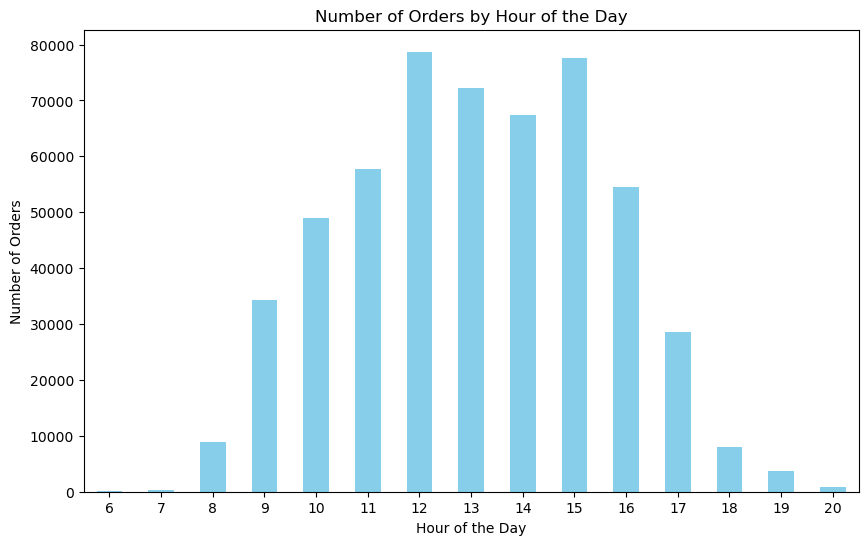

In [9]:
# Time of day when people buy often 

retail['Hour'] = retail['InvoiceDate'].dt.hour
hourly_orders = retail.groupby('Hour').size()
plt.figure(figsize = (10,6))
hourly_orders.plot(kind = 'bar' , color = 'skyblue')
plt.title('Number of Orders by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Orders')
plt.xticks(rotation = 0)
plt.show()

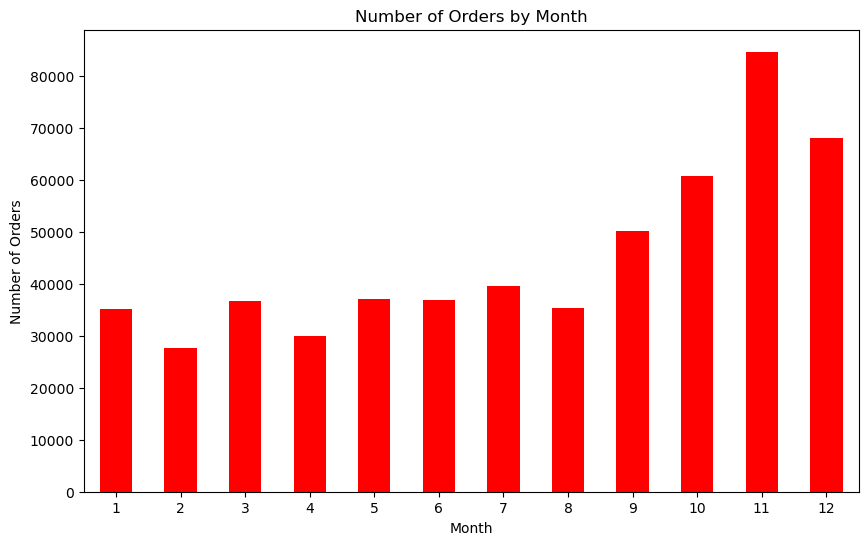

In [10]:
# Month of the year people buy often

retail['Month'] = retail['InvoiceDate'].dt.month
monthly_orders = retail.groupby('Month').size()
plt.figure(figsize = (10,6))
monthly_orders.plot(kind = 'bar',color = 'Red')
plt.title('Number of Orders by Month')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.xticks(rotation = 0)
plt.show()

In [11]:
# Average Value per order during Nov and Dec

nov_jan_orders = retail[(retail['InvoiceDate'].dt.month == 11) | (retail['InvoiceDate'].dt.month == 11)]
nov_jan_avg_value = nov_jan_orders.groupby('InvoiceDate')['UnitPrice'].sum().mean()
print('Average value per order during November and January:',nov_jan_avg_value )

Average value per order during November and January: 108.00589303400461


In [12]:
retail['TotalPrice'] = retail['Quantity'] * retail['UnitPrice']


november_data = retail[retail['InvoiceDate'].dt.month == 11]
january_data = retail[retail['InvoiceDate'].dt.month == 1]

# Total sales per order for November and January
november_totals = november_data.groupby('InvoiceNo')['TotalPrice'].sum()
january_totals = january_data.groupby('InvoiceNo')['TotalPrice'].sum()

# Average order value for November and January
average_order_value_november = november_totals.mean()
average_order_value_january = january_totals.mean()

print(f"Average Order Value for November: {average_order_value_november}")
print(f"Average Order Value for January: {average_order_value_january}")


Average Order Value for November: 422.22884170999424
Average Order Value for January: 379.4039701897019


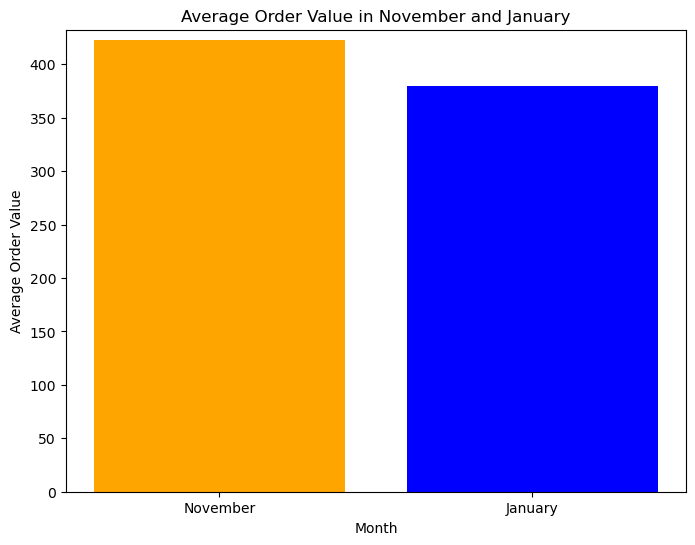

In [13]:

average_order_value_november = 422.22884170999424
average_order_value_january = 379.4039701897019

months = ['November', 'January']
average_values = [average_order_value_november, average_order_value_january]

plt.figure(figsize=(8, 6))
plt.bar(months, average_values, color=['orange', 'blue'])
plt.title('Average Order Value in November and January')
plt.xlabel('Month')
plt.ylabel('Average Order Value')
plt.ylim(0, max(average_values) + 10)
plt.show()


In [14]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
 8   Hour         541909 non-null  int64         
 9   Month        541909 non-null  int64         
 10  TotalPrice   541909 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 45.5+ MB


In [15]:
retail.describe()

,Quantity,UnitPrice,CustomerID,Hour,Month,TotalPrice
count,541909.000000,541909.000000,406829.000000,541909.000000,541909.000000,541909.000000
mean,9.552250,4.611114,15287.690570,13.078729,7.553128,17.987795
std,218.081158,96.759853,1713.600303,2.443270,3.509055,378.810824
min,-80995.000000,-11062.060000,12346.000000,6.000000,1.000000,-168469.600000
25%,1.000000,1.250000,13953.000000,11.000000,5.000000,3.400000
50%,3.000000,2.080000,15152.000000,13.000000,8.000000,9.750000
75%,10.000000,4.130000,16791.000000,15.000000,11.000000,17.400000
max,80995.000000,38970.000000,18287.000000,20.000000,12.000000,168469.600000


<b>
Now to get the data readdy for recommendation system we have to do the following cleaning processes.<br>
1.As per the metadata of data we see that some of the invoice code starts with C which indicates cancellation. So these are the orders which didn't get processed. Hence we will be removing these items from the dataset.<br>
2. Now as per the data bove we see that minimum value in Quanity column is Negative which is not possible. Hence we will remove the rows having these values negative<br>
3. Similar to Quantity column , Unit Price and Total Price  of an item cannot be negative. Hence we will be removing these values as well.


In [16]:
retail=retail[~retail['InvoiceNo'].astype(str).str.startswith('C')]

In [17]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 532621 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    532621 non-null  object        
 1   StockCode    532621 non-null  object        
 2   Description  531167 non-null  object        
 3   Quantity     532621 non-null  int64         
 4   InvoiceDate  532621 non-null  datetime64[ns]
 5   UnitPrice    532621 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      532621 non-null  object        
 8   Hour         532621 non-null  int64         
 9   Month        532621 non-null  int64         
 10  TotalPrice   532621 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 48.8+ MB


In [18]:
retail=retail[retail['Quantity']>=0]

In [19]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531285 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    531285 non-null  object        
 1   StockCode    531285 non-null  object        
 2   Description  530693 non-null  object        
 3   Quantity     531285 non-null  int64         
 4   InvoiceDate  531285 non-null  datetime64[ns]
 5   UnitPrice    531285 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      531285 non-null  object        
 8   Hour         531285 non-null  int64         
 9   Month        531285 non-null  int64         
 10  TotalPrice   531285 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 48.6+ MB


In [20]:
retail.describe()

,Quantity,UnitPrice,CustomerID,Hour,Month,TotalPrice
count,531285.000000,531285.000000,397924.000000,531285.000000,531285.000000,531285.00000
mean,10.655262,3.857296,15294.315171,13.076259,7.560244,20.03550
std,156.830323,41.810047,1713.169877,2.438303,3.508717,270.91237
min,1.000000,-11062.060000,12346.000000,6.000000,1.000000,-11062.06000
25%,1.000000,1.250000,13969.000000,11.000000,5.000000,3.75000
50%,3.000000,2.080000,15159.000000,13.000000,8.000000,9.90000
75%,10.000000,4.130000,16795.000000,15.000000,11.000000,17.70000
max,80995.000000,13541.330000,18287.000000,20.000000,12.000000,168469.60000


Again we see some columns having negative values so let us remove the rows having price as negative values

In [21]:
retail=retail[retail['UnitPrice']>=0]

In [22]:
retail.describe()

,Quantity,UnitPrice,CustomerID,Hour,Month,TotalPrice
count,531283.000000,531283.000000,397924.000000,531283.000000,531283.000000,531283.000000
mean,10.655299,3.898954,15294.315171,13.076255,7.560242,20.077218
std,156.830617,35.876279,1713.169877,2.438307,3.508723,270.058254
min,1.000000,0.000000,12346.000000,6.000000,1.000000,0.000000
25%,1.000000,1.250000,13969.000000,11.000000,5.000000,3.750000
50%,3.000000,2.080000,15159.000000,13.000000,8.000000,9.900000
75%,10.000000,4.130000,16795.000000,15.000000,11.000000,17.700000
max,80995.000000,13541.330000,18287.000000,20.000000,12.000000,168469.600000


In [23]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531283 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    531283 non-null  object        
 1   StockCode    531283 non-null  object        
 2   Description  530691 non-null  object        
 3   Quantity     531283 non-null  int64         
 4   InvoiceDate  531283 non-null  datetime64[ns]
 5   UnitPrice    531283 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      531283 non-null  object        
 8   Hour         531283 non-null  int64         
 9   Month        531283 non-null  int64         
 10  TotalPrice   531283 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 48.6+ MB


<b>
PROGRESS TILL WEEK 2 - <BR>
    1. Group members have completed the visualizations and derive actionable insights from the visualizations.<br>
    2. Group members have started the exploratory decision analysis on some columns like InvoiceNo , Quantity etc.
    <br>
    TASKS TO BE DONE TILL WEEK 3 - <br>
    1.Complete the exploratory decision anal
    
    

In [24]:
# Non-product related stock codes
non_product_codes = ['AMAZONFEE', 'BANK CHARGES', 'C2', 'DCGSSBOY', 'DCGSSGIRL',
                     'DOT', 'gift_0001_', 'PADS', 'POST']

# Removing them
retail = retail[~retail['StockCode'].isin(non_product_codes)]


In [25]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 529260 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    529260 non-null  object        
 1   StockCode    529260 non-null  object        
 2   Description  528674 non-null  object        
 3   Quantity     529260 non-null  int64         
 4   InvoiceDate  529260 non-null  datetime64[ns]
 5   UnitPrice    529260 non-null  float64       
 6   CustomerID   396660 non-null  float64       
 7   Country      529260 non-null  object        
 8   Hour         529260 non-null  int64         
 9   Month        529260 non-null  int64         
 10  TotalPrice   529260 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 48.5+ MB


In [26]:
# Unwanted descriptions that we will be removing
unwanted_descriptions = ["check", "check?", "?", "??", "damaged", "found", 
                          "adjustment", "Amazon", "AMAZON", "amazon adjust", 
                          "Amazon Adjustment", "amazon sales", "Found", "FOUND",
                          "found box", "Found by jackie ", "Found in w/hse", "dotcom",
                          "dotcom adjust", "allocate stock for dotcom orders ta", "FBA",
                          "Dotcomgiftshop Gift Voucher £100.00", "on cargo order",
                          "wrongly sold (22719) barcode", "wrongly marked 23343",
                          "dotcomstock", "rcvd be air temp fix for dotcom sit", "Manual",
                          "John Lewis", "had been put aside", "for online retail orders",  
                          "taig adjust", "amazon", "incorrectly credited C550456 see 47",
                          "returned", "wrongly coded 20713", "came coded as 20713", 
                          "add stock to allocate online orders", "Adjust bad debt",
                          "alan hodge cant mamage this section", "website fixed",
                          "did  a credit  and did not tick ret", "michel oops",
                          "incorrectly credited C550456 see 47", "mailout", "test",
                          "Sale error",  "Lighthouse Trading zero invc incorr", "SAMPLES",
                          "Marked as 23343", "wrongly coded 23343","Adjustment", 
                          "rcvd be air temp fix for dotcom sit", "Had been put aside."]

# Removing these rows
retail = retail[~retail['Description'].isin(unwanted_descriptions)]


In [27]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 528767 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    528767 non-null  object        
 1   StockCode    528767 non-null  object        
 2   Description  528181 non-null  object        
 3   Quantity     528767 non-null  int64         
 4   InvoiceDate  528767 non-null  datetime64[ns]
 5   UnitPrice    528767 non-null  float64       
 6   CustomerID   396370 non-null  float64       
 7   Country      528767 non-null  object        
 8   Hour         528767 non-null  int64         
 9   Month        528767 non-null  int64         
 10  TotalPrice   528767 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 48.4+ MB


In [28]:
# Removing rows where 'Description' is NaN
retail = retail.dropna(subset=['Description'])

In [29]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 528181 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    528181 non-null  object        
 1   StockCode    528181 non-null  object        
 2   Description  528181 non-null  object        
 3   Quantity     528181 non-null  int64         
 4   InvoiceDate  528181 non-null  datetime64[ns]
 5   UnitPrice    528181 non-null  float64       
 6   CustomerID   396370 non-null  float64       
 7   Country      528181 non-null  object        
 8   Hour         528181 non-null  int64         
 9   Month        528181 non-null  int64         
 10  TotalPrice   528181 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 48.4+ MB


In [30]:
# Checking NA values in 'CustomerID'
na_customer_ids = retail['CustomerID'].isna().sum()
print(f"Number of NA values in CustomerID: {na_customer_ids}")

# Checking the number of unique values in 'InvoiceNo' and 'CustomerID'
unique_invoices = retail['InvoiceNo'].nunique()
unique_customers = retail['CustomerID'].nunique()
print(f"Number of unique invoices: {unique_invoices}")
print(f"Number of unique customers: {unique_customers}")


Number of NA values in CustomerID: 131811
Number of unique invoices: 19794
Number of unique customers: 4335


This analysis shows customers averaging approximately 4.6 orders. This indicates a successful repeat purchase pattern and suggests focusing on retention strategies.

In [31]:
# Convert 'Description' and 'Country' to categorical types
retail['Description'] = retail['Description'].astype('category')
retail['Country'] = retail['Country'].astype('category')

# Extracting Date and Time from 'InvoiceDate'
retail['Date'] = retail['InvoiceDate'].dt.date
retail['Time'] = retail['InvoiceDate'].dt.time

In [32]:
retail['Date'] = retail['Date'].astype(str)

In [33]:
# Association Rules

In [34]:
def RecommendItemsViaAssociation(CurItemOfInterest, CustomerID, Country, Time, Date):
    
    # Filter data based on input parameters
    
    data = retail[(retail['CustomerID'] == CustomerID) & 
                         (retail['Country'] == Country) & 
                         (retail['Hour'] == Time) & 
                         (retail['Date'] == Date)]
    
    # Group items and transactions to find quantities purchased 
    # Rows represent transactions, Column represents item
    # Values represent the quantity of each item purchased in each transaction
    
    basket = (data.groupby(['InvoiceNo','Description'])['Quantity']
              .sum().unstack().reset_index().fillna(0)
              .set_index('InvoiceNo'))
    
    # Presence or Absence of items in each transaction is represented by binary values 
    # If quantity>0, returns 1; else returns 0
    
    basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)
    
    # Apriori calculates the support for all possible itemsets as in basket_sets
    # Returns only the itemsets that meet the specified min_support threshold.
    
    frequent_itemsets = apriori(basket_sets, min_support=0.05, use_colnames=True)
    
    # Calculate association rules based on lift metric
    # Purpose of using metric is to filter and identify the most meaningful rules among a potentially large set of rules generated by the algorithm.
    
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
    
    # Filter rules based on current item of interest
    
    filtered_rules = rules[rules['antecedents'].apply(lambda x: CurItemOfInterest in x)]
    
    # Below code to consider only one antecedent(A) and one consequent(B) in A->B
    
    filtered_rules = filtered_rules[(filtered_rules['antecedents'].apply(lambda x: len(x)) == 1) & 
                                (filtered_rules['consequents'].apply(lambda x: len(x)) == 1)]
    
    # Sort(desc) rules by confidence and return top 10
    
    sorted_rules = filtered_rules.sort_values(by='confidence', ascending=False).head(10)
    
    print(filtered_rules)
    
    return sorted_rules[['antecedents', 'consequents', 'confidence']]

In [35]:
recommendations = RecommendItemsViaAssociation('RED WOOLLY HOTTIE WHITE HEART.', 17850, 'United Kingdom', 8, '2010-12-01' )
print(recommendations)

                         antecedents                            consequents  \
5   (RED WOOLLY HOTTIE WHITE HEART.)       (CREAM CUPID HEARTS COAT HANGER)   
15  (RED WOOLLY HOTTIE WHITE HEART.)    (GLASS STAR FROSTED T-LIGHT HOLDER)   
25  (RED WOOLLY HOTTIE WHITE HEART.)  (KNITTED UNION FLAG HOT WATER BOTTLE)   
32  (RED WOOLLY HOTTIE WHITE HEART.)         (SET 7 BABUSHKA NESTING BOXES)   
35  (RED WOOLLY HOTTIE WHITE HEART.)   (WHITE HANGING HEART T-LIGHT HOLDER)   
37  (RED WOOLLY HOTTIE WHITE HEART.)                  (WHITE METAL LANTERN)   

    antecedent support  consequent support  support  confidence  lift  \
5                  0.5                 0.5      0.5         1.0   2.0   
15                 0.5                 0.5      0.5         1.0   2.0   
25                 0.5                 0.5      0.5         1.0   2.0   
32                 0.5                 0.5      0.5         1.0   2.0   
35                 0.5                 0.5      0.5         1.0   2.0   
37      

/Users/nimitnag/opt/anaconda3/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [37]:
# association_rule based on lift & sort by lift
# association_rule based on lift & sort by confidence
# association_rule based on confidence & sort by lift
# association_rule based on confidence & sort by confidence 
# Outputs are the same for all above combinations

In [38]:
# Lift is often considered the best metric for association rule mining  
# It not only measures the strength of association between items but also considers the frequency of the consequent in the absence of the antecedent. 
# A lift value greater than 1 indicates a positive association between items, making it a meaningful and interpretable measure for identifying interesting rules. 

In [39]:
# User Based Colloborative Filtering

In [44]:
def getTrainingAndTestingSets(data):
    reader=Reader(rating_scale=(1,10))
    result=Dataset.load_from_df(data[['CustomerID','Description','Month']],reader)
    trainset,testset=train_test_split(result,test_size=0.2)
    return trainset,testset

In [45]:
def getRecommendations(CurItemOfInterest, numberOfRecommendations,algo,trainset):
    item_factors = algo.qi
    item_similarities = cosine_similarity(item_factors)
    item_index = trainset.to_inner_iid(CurItemOfInterest)
    similar_items = np.argsort(item_similarities[item_index])[::-1][1:10]
    for i in similar_items:
        print(trainset.to_raw_iid(i))

In [46]:
def recommendItemsViaSVD(CurItemOfInterest, country,numberOfRecommendations):
    df=retail[retail['Country']==country]
    trainset,testset=getTrainingAndTestingSets(df)
    svd=SVD()
    svd.fit(trainset)
    print(accuracy.rmse(svd.test(testset)))
    getRecommendations(CurItemOfInterest, numberOfRecommendations,svd,trainset)

In [47]:
recommendItemsViaSVD('SET OF 4 PANTRY JELLY MOULDS','USA',10)

RMSE: 1.2487
1.2487067682444872
3 TRADITIONAl BISCUIT CUTTERS  SET
PAPER BUNTING COLOURED LACE
SET 2 PANTRY DESIGN TEA TOWELS
MEDIUM CERAMIC TOP STORAGE JAR
SET 12 COLOURING PENCILS DOILY
GREEN POLKADOT BOWL
CARD DOLLY GIRL 
CHILDRENS DOLLY GIRL MUG
PINK HAPPY BIRTHDAY BUNTING


<b>Item Based Collabrative Filtering</b>

In [48]:
import pandas as pd
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split

# Define the function
def RecommendItemsViaKNN(CurItemOfInterest, CustomerID, Country, Time, Date, retail):
    # Filter dataset based on country and customer
    retail = retail[(retail['Country'] == Country)]

    # Load data for Surprise
    reader = Reader(rating_scale=(1, 10))
    data = Dataset.load_from_df(retail[['CustomerID', 'Description', 'Month']], reader)
    
    # Define collaborative filtering algorithm
    sim_options = {
        'name': 'pearson',
        'user_based': False
    }
    knn = KNNWithZScore(sim_options=sim_options)
    trainset = data.build_full_trainset()
    knn.fit(trainset)
    inner_item_id = trainset.to_inner_iid(CurItemOfInterest)
    neighbors = knn.get_neighbors(inner_item_id, k=10)
    raw_neighbors = [trainset.to_raw_iid(inner_id) for inner_id in neighbors]
    for neighbor_id in raw_neighbors:
        print(neighbor_id)
    testset=trainset.build_testset()
    print(accuracy.rmse(knn.test(testset)))

In [49]:
 RecommendItemsViaKNN('SET OF 4 PANTRY JELLY MOULDS',12733.0,'USA', '16:19:00','2011-04-19', retail)
#print(recommendations)

Computing the pearson similarity matrix...
Done computing similarity matrix.
SET OF 6 SPICE TINS PANTRY DESIGN
PANTRY WASHING UP BRUSH
SET OF 36 TEATIME PAPER DOILIES
SET OF 3 CAKE TINS PANTRY DESIGN 
TEA TIME DES TEA COSY
SET 2 PANTRY DESIGN TEA TOWELS
 SET 2 TEA TOWELS I LOVE LONDON 
PARTY CONES CANDY ASSORTED
PINK HAPPY BIRTHDAY BUNTING
3 TRADITIONAl BISCUIT CUTTERS  SET
RMSE: 0.8456
0.845626276130704
